In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [2]:
X = iris["data"][:, (2, 3)] #petal length, petal width
y = iris["target"]

We need to add the bias term to the data $x_0=1$

In [3]:
X_with_bias = np.c_[np.ones([len(y), 1]), X]

Train test split from scratch 

In [4]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
training_size = total_size - test_size - validation_size

rndm_indices = np.random.permutation(total_size)

X_train = X_with_bias[rndm_indices[:training_size]]
y_train = y[rndm_indices[:training_size]]

X_test = X_with_bias[rndm_indices[-test_size:]]
y_test = y[rndm_indices[-test_size:]]

X_valid = X_with_bias[rndm_indices[training_size:-test_size]]
y_valid = y[rndm_indices[training_size:-test_size]]

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for ay given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance:

In [5]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    y_one_hot = np.zeros((m, n_classes))
    y_one_hot[np.arange(m), y] = 1
    return y_one_hot

Test this function on the first 10 instances

In [6]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [7]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [8]:
y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)
y_valid_one_hot = to_one_hot(y_valid)

Implementation of the Softmax Function

In [9]:
def softmax(logits):
    exps = np.exp(logits)
    exps_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exps_sums

Let's define the number of outputs and inputs

In [10]:
n_inputs = X_train.shape[-1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y))
n_inputs, n_outputs

(3, 3)

In [11]:
X_train.shape

(90, 3)

Training process:

In [12]:
eta = 0.01 # learning rate
n_iterations = 5001
m = len(X_train) #number of instances in training set
epsilon = 1e-7 # value for avoiding NaN results in logaritmic calc

theta = np.random.randn(n_inputs, n_outputs)

for i in range(n_iterations):
    logits = X_train.dot(theta)
    y_proba = softmax(logits)
    if i % 500 == 0:
        loss = -np.mean(np.sum(y_train_one_hot * np.log(y_proba + epsilon), axis=1))
        print(i, loss)
    error = y_proba - y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    theta = theta - eta * gradients

0 3.5356045081790177
500 0.7698276617097014
1000 0.6394784332731978
1500 0.5618741363839648
2000 0.5095831080853221
2500 0.47127377559909317
3000 0.44155863305230325
3500 0.41755986648041216
4000 0.3975941721521857
4500 0.38060484552797946
5000 0.3658905593000995


In [13]:
theta

array([[ 2.44942005, -1.63172695, -3.63642175],
       [-0.61947541,  0.50273412,  0.22142236],
       [-0.96378971,  0.39312153,  2.48742003]])

Test on validation set:

In [14]:
logits = X_valid.dot(theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

Add $l_2$ regularization

In [15]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 # regularization hyperparameter

theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(theta)
    y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(y_train_one_hot*np.log(y_proba+epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = y_proba - y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * theta[1:]]
    theta = theta - eta * gradients

0 4.074160805836161
500 0.5159746132958636
1000 0.49124622842160703
1500 0.4842826626269517
2000 0.4817288114918939
2500 0.4807092367289707
3000 0.4802846688736693
3500 0.48010354679755274
4000 0.4800251331504283
4500 0.4799908689215817
5000 0.47997580701829323


In [16]:
logits = X_valid.dot(theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

Now add Early Stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [17]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(theta)
    y_proba = softmax(logits)
    error = y_proba - y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * theta[1:]]
    theta = theta - eta * gradients
    
    logits = X_valid.dot(theta)
    y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(y_valid_one_hot*np.log(y_proba+epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 1.7715206020472196
500 0.5707532983595428
1000 0.5459468821986381
1500 0.5380948912189549
2000 0.5349265834600063
2500 0.5335454107098025
3000 0.5329073608729563
3500 0.5325963465739498
4000 0.5324366553661258
4500 0.5323504675033872
5000 0.5323017576862805


In [18]:
logits = X_valid.dot(theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

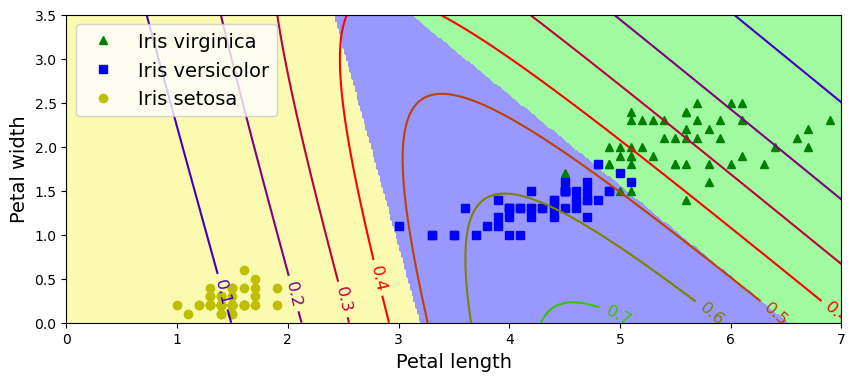

In [19]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

Let's see the accuracy on the test set:

In [20]:
logits = X_test.dot(theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9666666666666667